In [384]:
import pandas as pd
from datetime import datetime
!pip install sodapy
!pip install folium
!pip install plotly
!pip install seaborn
!pip install altair
from sodapy import Socrata
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from functools import reduce
from folium.plugins import HeatMapWithTime
import folium.plugins as plugins  
from folium import Map
from folium import features
import altair as alt
import json


import warnings
warnings.filterwarnings('ignore')


In [273]:
!pip install folium --upgrade

In [275]:
#Read and view AFL Data
#afl_df = pd.read_csv('/content/drive/MyDrive/afl_data.csv')

afl_df = pd.read_csv('afl_data.csv')
afl_df.head()

,gameId,year,round,date,venue,startTime,attendance,homeTeam,awayTeam,rainfall
0,2022R504,2022,R4,10-Apr-22,M.C.G.,15:20,30926,Hawthorn,St Kilda,0.0
1,2022R403,2022,R4,10-Apr-22,Docklands,13:10,24906,Essendon,Adelaide,0.0
2,2022R402,2022,R4,09-Apr-22,M.C.G.,19:25,43645,Richmond,Western Bulldogs,0.0
3,2022R401,2022,R4,09-Apr-22,Docklands,16:35,25897,Collingwood,West Coast,0.0
4,2022R305,2022,R3,03-Apr-22,Docklands,15:20,31933,St Kilda,Richmond,1.8


In [276]:
#Standardise the datatime data
afl_df['startTime'] = pd.to_datetime(afl_df['startTime'], format = '%H:%M')

afl_df.date = pd.to_datetime(afl_df.date, format = '%d-%b-%y')
afl_df['day_of_week'] = afl_df['date'].dt.day_name()

afl_df['StartHour'] = pd.to_datetime(afl_df['startTime'], format='%H:%M:%S').dt.hour
afl_df['StartMinute'] = pd.to_datetime(afl_df['startTime'], format='%H:%M:%S').dt.minute

In [277]:
afl_df.dtypes

gameId                 object
year                    int64
round                  object
date           datetime64[ns]
venue                  object
startTime      datetime64[ns]
attendance              int64
homeTeam               object
awayTeam               object
rainfall              float64
day_of_week            object
StartHour               int64
StartMinute             int64
dtype: object

In [278]:
#Generate start time categories
afl_df['timeslot'] = pd.to_datetime(afl_df['startTime'])
afl_df['timeslot'] = afl_df['timeslot'].dt.strftime("%H:%M:%S")
afl_df['timeslot'] = afl_df['timeslot'].apply(lambda x: 'Afternoon' if x <= '16:00:00' else 'Evening')
afl_df['start'] = afl_df['startTime'].dt.strftime("%H-%M-%S")

## Extract game date data

In [279]:
game_dates_list = pd.unique((afl_df.date).dt.strftime('%Y-%m-%d')).tolist()

afternoons_dates = afl_df[(afl_df.timeslot == 'Afternoon')]
afternoons_dates_list = pd.unique((afternoons_dates.date).dt.strftime('%Y-%m-%d')).tolist()

evening_dates = afl_df[(afl_df.timeslot == 'Evening')]
evening_dates_list = pd.unique((evening_dates.date).dt.strftime('%Y-%m-%d')).tolist()


MCG_dates = afl_df[(afl_df.venue == 'M.C.G.')]
MCG_dates_list = pd.unique((MCG_dates.date).dt.strftime('%Y-%m-%d')).tolist()

Docklands_dates = afl_df[(afl_df.timeslot == 'Docklands')]
Docklands_dates_list = pd.unique((Docklands_dates.date).dt.strftime('%Y-%m-%d')).tolist()

In [280]:
#Pedestrian data
client = Socrata('data.melbourne.vic.gov.au', 'jkWLqYGpmFN5bK6j45TU4peYP', None)
results = client.get("b2ak-trbp", limit=7000000)

pedestrian_df = pd.DataFrame.from_records(results)
#pedestrian_df['sensor_id'] = pedestrian_df['sensor_id'].astype(int)

In [281]:
#View pedestrian data
pedestrian_df.head(5).T

,0,1,2,3,4
id,2887628,2887629,2887630,2887631,2887632
date_time,2019-11-01T17:00:00.000,2019-11-01T17:00:00.000,2019-11-01T17:00:00.000,2019-11-01T17:00:00.000,2019-11-01T17:00:00.000
year,2019,2019,2019,2019,2019
month,November,November,November,November,November
mdate,1,1,1,1,1
day,Friday,Friday,Friday,Friday,Friday
time,17,17,17,17,17
sensor_id,34,39,37,40,36
sensor_name,Flinders St-Spark La,Alfred Place,Lygon St (East),Lonsdale St-Spring St (West),Queen St (West)
hourly_counts,300,604,216,627,774


In [282]:
#Location data
client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
ped_data_location = "h57g-5234"
results = client.get(ped_data_location)
sensor_location = pd.DataFrame.from_records(results)
sensor_location[['latitude', 'longitude']] = sensor_location[['latitude', 'longitude']].astype(float)
#sensor_location['sensor_id'] = sensor_location['sensor_id'].astype(str)

In [283]:
#View sensor data
sensor_location.head(5).T

,0,1,2,3,4
sensor_id,55,45,61,7,72
sensor_description,Elizabeth St-La Trobe St (East),Little Collins St-Swanston St (East),RMIT Building 14,Birrarung Marr,Flinders St- ACMI
sensor_name,Eli380_T,Swa148_T,RMIT14_T,Fed_T,ACMI_T
installation_date,2018-07-19T00:00:00.000,2017-06-29T00:00:00.000,2019-06-28T00:00:00.000,2014-12-17T00:00:00.000,2020-11-30T00:00:00.000
status,A,A,A,A,A
direction_1,North,North,North,East,East
direction_2,South,South,South,West,West
latitude,-37.809889,-37.814141,-37.807675,-37.818629,-37.817263
longitude,144.961343,144.966094,144.963091,144.971694,144.968728
location,"{'latitude': '-37.80988941', 'longitude': '144...","{'latitude': '-37.81414074', 'longitude': '144...","{'latitude': '-37.80767455', 'longitude': '144...","{'latitude': '-37.81862929', 'longitude': '144...","{'latitude': '-37.81726337', 'longitude': '144..."


In [284]:
sensor_location.dtypes

sensor_id              object
sensor_description     object
sensor_name            object
installation_date      object
status                 object
direction_1            object
direction_2            object
latitude              float64
longitude             float64
location               object
note                   object
dtype: object

In [285]:
#Plot location of sensors

map = folium.Map(location=[sensor_location.latitude.mean(), 
                           sensor_location.longitude.mean()], 
                          zoom_start=14, min_zoom=14, max_zoom = 16,max_bounds=True)

for i in range(0,len(sensor_location)):
    folium.Marker(location = [sensor_location.iloc[i]['latitude'], 
                            sensor_location.iloc[i]['longitude']], 
                            popup = sensor_location.iloc[i]['sensor_id']).add_to(map)

map

In [286]:
#best_sensor_location = sensor_location[sensor_location.sensor_id.isin([9,10,2,6,18,8,11,1,5,12,3,14,31,13])]


map = folium.Map(location=[sensor_location.latitude.mean(), 
                           sensor_location.longitude.mean()], 
                          zoom_start=14, control_scale=True)

for i in range(0,len(sensor_location)):
    folium.Marker(location = [sensor_location.iloc[i]['latitude'], 
                            sensor_location.iloc[i]['longitude']], 
                            popup = sensor_location.iloc[i]['sensor_id'],).add_to(map)
map

## Merge dataframes

In [287]:
pedestrian_df.dtypes

id               object
date_time        object
year             object
month            object
mdate            object
day              object
time             object
sensor_id        object
sensor_name      object
hourly_counts    object
dtype: object

In [288]:
merged_df = pd.merge(pedestrian_df, sensor_location, on = 'sensor_id')

In [289]:
merged_df = merged_df[['date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id',
       'sensor_name_x', 'hourly_counts','latitude',
       'longitude']]

In [290]:
merged_df['date_time'] = pd.to_datetime(merged_df['date_time'])
merged_df['date'] = merged_df['date_time'].dt.strftime("%Y-%m-%d")

In [291]:
merged_df = merged_df.sort_values(['date_time'], ascending = True)
merged_df['hourly_counts'] = merged_df['hourly_counts'].astype(int)
merged_df['day'] = merged_df['day'].astype(str)

In [292]:
#merged_df['date_time'] = pd.to_datetime(merged_df['date_time'])
merged_df['year'] = merged_df['year'].astype(int)
merged_df['mdate'] = merged_df['mdate'].astype(int)
merged_df['time'] = merged_df['time'].astype(int)
merged_df['hourly_counts'] = merged_df['hourly_counts'].astype(int)
merged_df['year'] = merged_df['year'].astype(int)
merged_df['sensor_id'] = merged_df['sensor_id'].astype(int)

In [293]:
#adjust dataframe to AFL data
merged_df.reset_index(inplace =True)
afl_merged_df = merged_df[merged_df.date > '2012-03-29']

merged_df2 = merged_df.copy()

In [294]:
afl_merged_df.sensor_id.value_counts().sort_values(ascending = False).head(12)

10    88281
2     88171
9     88145
6     87977
18    87231
8     86953
11    86892
1     85819
5     85052
12    84901
3     83434
14    82290
Name: sensor_id, dtype: int64

In [295]:
#Extract game and and non game data
afl_df = afl_merged_df[merged_df['date'].isin(game_dates_list)]
non_afl_df = afl_merged_df[~merged_df['date'].isin(game_dates_list)]

In [296]:
afl_df.head()

,index,date_time,year,month,mdate,day,time,sensor_id,sensor_name_x,hourly_counts,latitude,longitude,date
441888,3893701,2012-03-30,2012,March,30,Friday,0,13,Flagstaff Station,30,-37.812397,144.956527,2012-03-30
441889,2769635,2012-03-30,2012,March,30,Friday,0,6,Flinders Street Station Underpass,213,-37.819117,144.965583,2012-03-30
441890,2229651,2012-03-30,2012,March,30,Friday,0,12,New Quay,25,-37.814580,144.942924,2012-03-30
441891,1410967,2012-03-30,2012,March,30,Friday,0,18,Collins Place (North),31,-37.813449,144.973054,2012-03-30
441892,1195578,2012-03-30,2012,March,30,Friday,0,4,Town Hall (West),569,-37.814880,144.966088,2012-03-30


In [297]:
non_afl_df.head()

,index,date_time,year,month,mdate,day,time,sensor_id,sensor_name_x,hourly_counts,latitude,longitude,date
443184,2003967,2012-04-02,2012,April,2,Monday,0,9,Southern Cross Station,6,-37.819830,144.951026,2012-04-02
443185,1795954,2012-04-02,2012,April,2,Monday,0,3,Melbourne Central,172,-37.811015,144.964295,2012-04-02
443186,1581090,2012-04-02,2012,April,2,Monday,0,2,Bourke Street Mall (South),25,-37.813807,144.965167,2012-04-02
443187,2117231,2012-04-02,2012,April,2,Monday,0,10,Victoria Point,11,-37.818765,144.947105,2012-04-02
443188,1685077,2012-04-02,2012,April,2,Monday,0,1,Bourke Street Mall (North),39,-37.813494,144.965153,2012-04-02


In [298]:
#Generate average pedestraian movements per hour
afl = pd.DataFrame(afl_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
afl.reset_index(inplace = True)

non_afl = pd.DataFrame(non_afl_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
non_afl.reset_index(inplace = True)

In [299]:
afl_merged_df.sensor_id.value_counts()

10    88281
2     88171
9     88145
6     87977
18    87231
      ...  
77     8760
78     8760
79     5304
73     3648
60     2291
Name: sensor_id, Length: 78, dtype: int64

In [300]:
#Combine AFL and Non-AFL Data
afl_merged_df= non_afl.merge(afl, on=["sensor_id","year", "day", "time"])
afl_merged_df.drop(['latitude_x', 'longitude_x'], axis=1, inplace=True)
afl_merged_df = afl_merged_df.rename(columns = {'latitude_y':'latitude','longitude_y':'longitude' })
afl_merged_df = afl_merged_df.rename(columns = {'hourly_counts_x':'No_AFL','hourly_counts_y':'AFL' })

merged_data_diff = afl_merged_df.copy()
merged_data_diff['diff'] = afl_merged_df.AFL - afl_merged_df.No_AFL
#merged_data_diff['diff'] = merged_data_diff['diff'].astype(float)
#merged_df2 = merged_data.copy()
#merged_data.drop(['latitude', 'longitude'], axis=1, inplace=True)

#merged_data_diff['diff'] = (merged_data_diff['diff']-merged_data_diff['diff'].min())/(merged_data_diff['diff'].max()-merged_data_diff['diff'].min()


In [301]:
afl_merged_df = afl_merged_df.rename(columns = {'hourly_counts_x':'No_AFL','hourly_counts_y':'AFL' })
afl_merged_df

,sensor_id,year,day,time,No_AFL,latitude,longitude,AFL
0,1,2012,Friday,0,100.666667,-37.813494,144.965153,57.736842
1,1,2012,Friday,1,53.476190,-37.813494,144.965153,37.684211
2,1,2012,Friday,2,30.523810,-37.813494,144.965153,22.157895
3,1,2012,Friday,3,23.428571,-37.813494,144.965153,16.000000
4,1,2012,Friday,4,19.428571,-37.813494,144.965153,14.368421
...,...,...,...,...,...,...,...,...
63181,79,2022,Wednesday,19,479.142857,-37.817940,144.966167,580.000000
63182,79,2022,Wednesday,20,391.642857,-37.817940,144.966167,415.000000
63183,79,2022,Wednesday,21,378.928571,-37.817940,144.966167,495.000000
63184,79,2022,Wednesday,22,314.642857,-37.817940,144.966167,1263.000000


In [302]:
merged_data_diff = afl_merged_df.copy()
merged_data_diff['diff'] = (afl_merged_df.AFL - afl_merged_df.No_AFL)/afl_merged_df.AFL
merged_data_diff

,sensor_id,year,day,time,No_AFL,latitude,longitude,AFL,diff
0,1,2012,Friday,0,100.666667,-37.813494,144.965153,57.736842,-0.743543
1,1,2012,Friday,1,53.476190,-37.813494,144.965153,37.684211,-0.419061
2,1,2012,Friday,2,30.523810,-37.813494,144.965153,22.157895,-0.377559
3,1,2012,Friday,3,23.428571,-37.813494,144.965153,16.000000,-0.464286
4,1,2012,Friday,4,19.428571,-37.813494,144.965153,14.368421,-0.352172
...,...,...,...,...,...,...,...,...,...
63181,79,2022,Wednesday,19,479.142857,-37.817940,144.966167,580.000000,0.173892
63182,79,2022,Wednesday,20,391.642857,-37.817940,144.966167,415.000000,0.056282
63183,79,2022,Wednesday,21,378.928571,-37.817940,144.966167,495.000000,0.234488
63184,79,2022,Wednesday,22,314.642857,-37.817940,144.966167,1263.000000,0.750877


In [303]:
afl_merged_df = afl_merged_df.melt(["sensor_id", "year", "day", "time", "latitude", "longitude"],var_name="AFL",value_name="PedestrianCount")
afl_merged_df

,sensor_id,year,day,time,latitude,longitude,AFL,PedestrianCount
0,1,2012,Friday,0,-37.813494,144.965153,No_AFL,100.666667
1,1,2012,Friday,1,-37.813494,144.965153,No_AFL,53.476190
2,1,2012,Friday,2,-37.813494,144.965153,No_AFL,30.523810
3,1,2012,Friday,3,-37.813494,144.965153,No_AFL,23.428571
4,1,2012,Friday,4,-37.813494,144.965153,No_AFL,19.428571
...,...,...,...,...,...,...,...,...
126367,79,2022,Wednesday,19,-37.817940,144.966167,AFL,580.000000
126368,79,2022,Wednesday,20,-37.817940,144.966167,AFL,415.000000
126369,79,2022,Wednesday,21,-37.817940,144.966167,AFL,495.000000
126370,79,2022,Wednesday,22,-37.817940,144.966167,AFL,1263.000000


In [304]:
#Check for duplicate dates
list1 = afl_df.date_time
list2 = non_afl_df.date_time

if any(x in list1 for x in list2):
    print("Duplicates found.")
else:
    print("No duplicates found.")

No duplicates found.


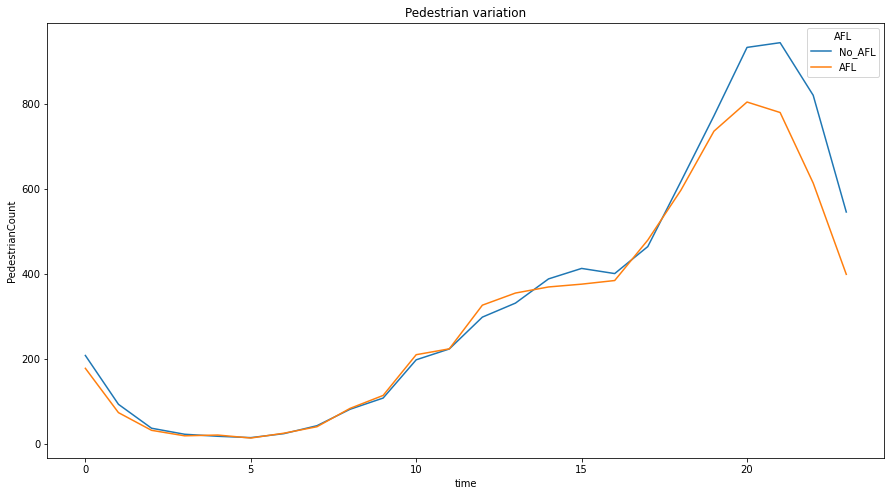

In [305]:
#Plot afl v non-afl movmeents, enter sensor_id, year and day of the week

plt.figure(figsize=(15,8))
sns.lineplot(x='time', y='PedestrianCount', hue='AFL', 
             data = afl_merged_df[(afl_merged_df.sensor_id == 31) & 
                                (afl_merged_df.year == 2019) & 
                                (afl_merged_df.day == 'Saturday')]).set_title('Pedestrian variation')

plt.show()

In [306]:
def PedestrianVar(year, day, *sensor_ids):
  m = folium.Map(location=[sensor_location.latitude.mean(), 
                            sensor_location.longitude.mean()], 
                            zoom_start=14, control_scale=True, min_zoom=14, max_zoom = 16)

  for i in sensor_ids:
    data = afl_merged_df[(afl_merged_df.sensor_id == i) & 
                                (afl_merged_df.year == year) & 
                                (afl_merged_df.day == day)]

    pedestrian_chart = alt.Chart(data).mark_line().encode(
      x='time',
      y='PedestrianCount',
      color='AFL')
    
    chart = json.loads(pedestrian_chart.to_json())

    popup = folium.Popup(max_width=350)
    folium.features.VegaLite(chart, height=200, width=350).add_to(popup)
    folium.Marker([data.iloc[i]['latitude'], 
                              data.iloc[i]['longitude']], tooltip = data.iloc[i]['sensor_id'], popup=popup).add_to(m)

  return(m)

In [307]:
pedestrian_variance = PedestrianVar(2015, 'Sunday',7,9,10,2,6,18,8,11)
pedestrian_variance

**Differentiate between start times, before 4pm is Afternoon, after 4pm is considered evening.**

In [308]:
#Extract afternoon and evening data
afl_afternoon_df = afl_df[afl_df['date'].isin(afternoons_dates_list)]
afl_evening_df = afl_df[~afl_df['date'].isin(afternoons_dates_list)]

afl_afternoon_df2 = pd.DataFrame(afl_afternoon_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
afl_afternoon_df2.reset_index(inplace = True)

afl_evening_df2 = pd.DataFrame(afl_evening_df.groupby(['sensor_id', 'year', 'day','time','latitude', 'longitude'])['hourly_counts'].mean())
afl_evening_df2.reset_index(inplace = True)
#non_afl.drop(['latitude', 'longitude'], axis=1, inplace=True)
dfs = [afl_evening_df2,afl_afternoon_df2,non_afl]

In [309]:
final_df = reduce(lambda  left,right: pd.merge(left,right,on=["sensor_id", "year", "day", "time"],
                                            how='outer'), dfs)
final_df = final_df.rename(columns = {'hourly_counts_x':'Evening','hourly_counts_y':'Afternoon', 'hourly_counts': 'No AFL'})
final_df.drop(['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y'], axis=1, inplace=True)
time_merged_data = final_df.melt(["sensor_id", "year", "day", "time", "latitude", "longitude"],var_name="AFL",value_name="hourly_counts")


In [310]:
time_merged_data.head()

,sensor_id,year,day,time,latitude,longitude,AFL,hourly_counts
0,1,2012,Friday,0,-37.813494,144.965153,Evening,57.736842
1,1,2012,Friday,1,-37.813494,144.965153,Evening,37.684211
2,1,2012,Friday,2,-37.813494,144.965153,Evening,22.157895
3,1,2012,Friday,3,-37.813494,144.965153,Evening,16.000000
4,1,2012,Friday,4,-37.813494,144.965153,Evening,14.368421


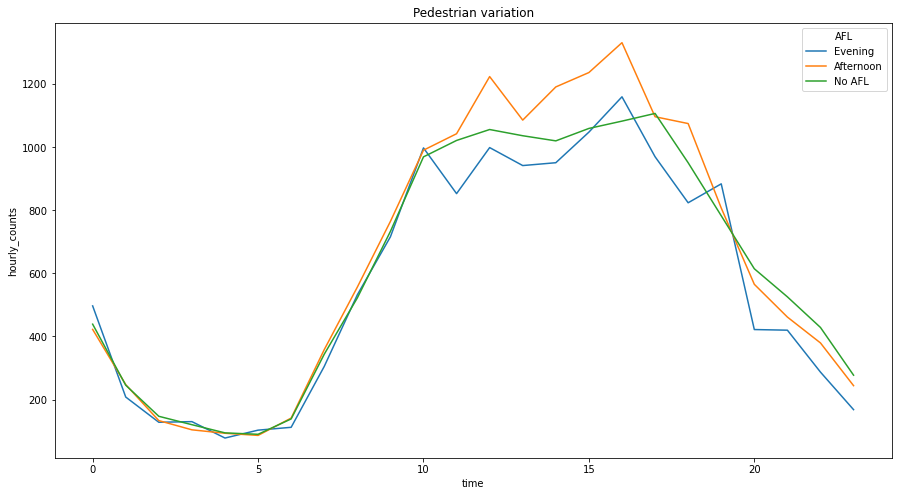

In [311]:
#Plot non-afl v afternoon v evening movements, enter sensor_id, year and day of the week


plt.figure(figsize=(15,8))
sns.lineplot(x='time', y='hourly_counts', hue='AFL', 
             data = time_merged_data[(time_merged_data.sensor_id == 24) & 
                                (time_merged_data.year == 2016) & 
                                (time_merged_data.day == 'Sunday')]).set_title('Pedestrian variation')

plt.show()

In [380]:
def TimeVar(year, day, *sensor_ids):

  m = folium.Map(location=[sensor_location.latitude.mean(), 
                            sensor_location.longitude.mean()], 
                            zoom_start=15, control_scale=False, min_zoom=14, max_zoom = 16)

  for i in sensor_ids:
    data = time_merged_data[(time_merged_data.sensor_id == i) & 
                                (time_merged_data.year == 2016) & 
                                (time_merged_data.day == 'Sunday')]

    pedestrian_chart = alt.Chart(data).mark_line().encode(
      x='time',
      y='hourly_counts',
      color='AFL')
    
    chart = json.loads(pedestrian_chart.to_json())

    popup = folium.Popup(max_width=350)
    folium.features.VegaLite(chart, height=200, width=350).add_to(popup)
    folium.Marker([data.iloc[i]['latitude'], 
                              data.iloc[i]['longitude']], tooltip = data.iloc[i]['sensor_id'], popup=popup).add_to(m)

  return(m)

In [381]:
PedestrianVariance = TimeVar(2014, 'Saturday',7,9,10,2,6,18,8,11,1,5,12,3,14,31)
PedestrianVariance

**Differentiate between grounds, MCG or Docklands.**

In [314]:
#Extract ground data
afl_mcg_df = afl_df[afl_df['date'].isin(MCG_dates_list)]
afl_docklands_df = afl_df[~afl_df['date'].isin(MCG_dates_list)]

afl_mcg_df2 = pd.DataFrame(afl_mcg_df.groupby(['sensor_id', 'year', 'day','time','latitude', 'longitude'])['hourly_counts'].mean())
afl_mcg_df2.reset_index(inplace = True)

afl_docklands_df2 = pd.DataFrame(afl_docklands_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
afl_docklands_df2.reset_index(inplace = True)

dfs = [afl_mcg_df2,afl_docklands_df2,non_afl]

In [315]:
final_df = reduce(lambda  left,right: pd.merge(left,right,on=["sensor_id", "year", "day", "time"],
                                            how='outer'), dfs)
final_df = final_df.rename(columns = {'hourly_counts_x':'MCG','hourly_counts_y':'Docklands', 'hourly_counts': 'No AFL'})
final_df.drop(['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y'], axis=1, inplace=True)
time_merged_data = final_df.melt(["sensor_id", "year", "day", "time", "latitude", "longitude"],var_name="AFL",value_name="hourly_counts")


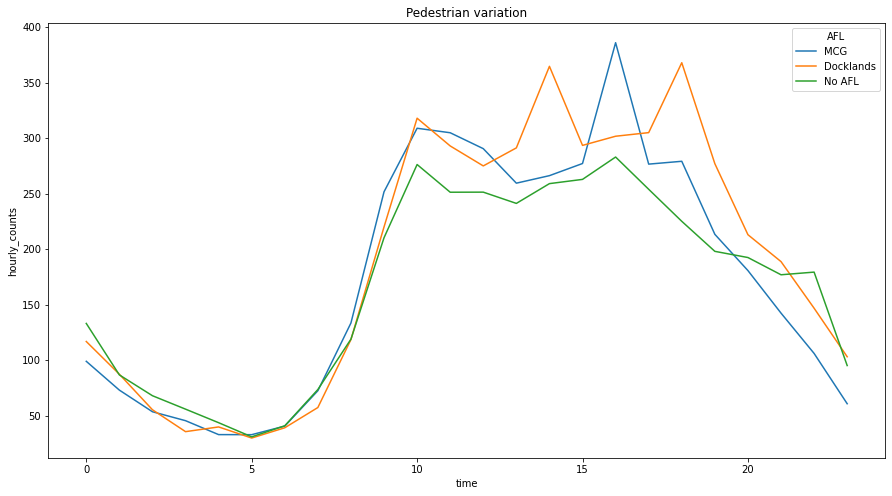

In [316]:
#Plot non-afl v afternoon v evening movements, enter sensor_id, year and day of the week


plt.figure(figsize=(15,8))
sns.lineplot(x='time', y='hourly_counts', hue='AFL', 
             data = time_merged_data[(time_merged_data.sensor_id == 23) & 
                                (time_merged_data.year == 2017) & 
                                (time_merged_data.day == 'Sunday')]).set_title('Pedestrian variation')

plt.show()

In [317]:
def GroundVar(year, day, *sensor_ids):
  m = folium.Map(location=[sensor_location.latitude.mean(), 
                            sensor_location.longitude.mean()], 
                            zoom_start=13, control_scale=True, min_zoom=14, max_zoom = 16)

  for i in sensor_ids:
    data = time_merged_data[(time_merged_data.sensor_id == i) & 
                                (time_merged_data.year == 2016) & 
                                (time_merged_data.day == 'Saturday')]

    pedestrian_chart = alt.Chart(data).mark_line().encode(
      x='time',
      y='hourly_counts',
      color='AFL')
    
    chart = json.loads(pedestrian_chart.to_json())

    popup = folium.Popup(max_width=350)
    folium.features.VegaLite(chart, height=200, width=350).add_to(popup)
    folium.Marker([data.iloc[i]['latitude'], 
                              data.iloc[i]['longitude']], tooltip = data.iloc[i]['sensor_id'], popup=popup).add_to(m)

  return(m)

In [318]:
PedestrianVariance = GroundVar(2014, 'Sunday',7,9,10,2,6,18,8,11,1,5,12,3,14,31,13)
PedestrianVariance

In [319]:
merged_data_diff2 = merged_data_diff[(merged_data_diff.year == 2013) & (merged_data_diff.day == 'Friday')]
merged_data_diff2

,sensor_id,year,day,time,No_AFL,latitude,longitude,AFL,diff
120,1,2013,Friday,0,110.794118,-37.813494,144.965153,88.944444,-0.245655
121,1,2013,Friday,1,66.117647,-37.813494,144.965153,47.944444,-0.379047
122,1,2013,Friday,2,41.058824,-37.813494,144.965153,24.222222,-0.695089
123,1,2013,Friday,3,28.470588,-37.813494,144.965153,20.722222,-0.373916
124,1,2013,Friday,4,21.794118,-37.813494,144.965153,15.055556,-0.447580
...,...,...,...,...,...,...,...,...,...
33734,28,2013,Friday,19,1571.357143,-37.821299,144.968793,1457.000000,-0.078488
33735,28,2013,Friday,20,759.071429,-37.821299,144.968793,373.000000,-1.035044
33736,28,2013,Friday,21,1050.500000,-37.821299,144.968793,322.000000,-2.262422
33737,28,2013,Friday,22,918.000000,-37.821299,144.968793,1417.000000,0.352152


In [320]:
merged_data_diff2 = merged_data_diff[(merged_data_diff.year == 2018) & (merged_data_diff.day == 'Monday')]


data = []
for _, d in merged_data_diff2.groupby('time'):
    data.append([[row['latitude'], row['longitude'], row['diff']] for _, row in d.iterrows()])

time_index = [k[0] for k in merged_data_diff2.groupby('time')]

In [321]:
def VarHeatMap(year, day):
    merged_data_diff2 = merged_data_diff[(merged_data_diff.year == year) & (merged_data_diff.day == day)]
    data = []
    for _, d in merged_data_diff2.groupby('time'):
        data.append([[row['latitude'], row['longitude'], row['diff']] for _, row in d.iterrows()])

    time_index = [k[0] for k in merged_data_diff2.groupby('time')]




    map= folium.Map(location=[sensor_location.latitude.mean(), 
                               sensor_location.longitude.mean()],
                                zoom_start=14)


    hm = HeatMapWithTime(data, index = time_index, name = 'Heat Map',auto_play=True, 
                    min_opacity=.5, 
                    gradient = {0.05: 'blue', 
                                0.1: 'green', 
                                0.3: 'orange', 
                                0.45: 'red'}).add_to(map)
    return(map)

In [322]:
VarHeatMap(2016, 'Sunday')

In [323]:
gp_dates = pd.read_csv('gp_dates.csv' )

In [340]:
gp_dates['date'] = pd.to_datetime(gp_dates['date'])

gp_dates = gp_dates[gp_dates.date> '1999-01-01']
gp_dates_list = pd.unique((gp_dates.date).dt.strftime('%Y-%m-%d')).tolist()

In [341]:
gp_dates.head()

,date
6,1999-05-03
7,1999-06-03
8,1999-07-03
9,2000-10-03
10,2000-11-03


In [385]:
gp_dates_list[:5]

['1999-05-03', '1999-06-03', '1999-07-03', '2000-10-03', '2000-11-03']

In [328]:
gp_dates_list[:5]

['1997-07-03', '1997-08-03', '1997-09-03', '1998-06-03', '1998-07-03']

In [332]:
merged_df

,index,date_time,year,month,mdate,day,time,sensor_id,sensor_name_x,hourly_counts,latitude,longitude,date
0,1866565,2009-05-01 00:00:00,2009,May,1,Friday,0,15,State Library,124,-37.810644,144.964471,2009-05-01
1,2303117,2009-05-01 00:00:00,2009,May,1,Friday,0,11,Waterfront City,5,-37.815650,144.939707,2009-05-01
2,3925461,2009-05-01 00:00:00,2009,May,1,Friday,0,16,Australia on Collins,22,-37.815734,144.965210,2009-05-01
3,1965608,2009-05-01 00:00:00,2009,May,1,Friday,0,9,Southern Cross Station,5,-37.819830,144.951026,2009-05-01
4,2844861,2009-05-01 00:00:00,2009,May,1,Friday,0,14,Sandridge Bridge,95,-37.820112,144.962919,2009-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264127,315838,2022-04-30 23:00:00,2022,April,30,Saturday,23,36,Queen St (West),381,-37.816525,144.961211,2022-04-30
4264128,2730635,2022-04-30 23:00:00,2022,April,30,Saturday,23,5,Princes Bridge,1218,-37.818742,144.967877,2022-04-30
4264129,2951974,2022-04-30 23:00:00,2022,April,30,Saturday,23,14,Sandridge Bridge,411,-37.820112,144.962919,2022-04-30
4264130,3174103,2022-04-30 23:00:00,2022,April,30,Saturday,23,23,Spencer St-Collins St (South),260,-37.819093,144.954527,2022-04-30


In [343]:
gp_df = merged_df[merged_df['date'].isin(gp_dates_list)]
non_gp_df = merged_df[~merged_df['date'].isin(gp_dates_list)]

In [347]:
#Generate average pedestraian movements per hour
gp = pd.DataFrame(gp_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
gp.reset_index(inplace = True)

non_gp = pd.DataFrame(non_gp_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
non_gp.reset_index(inplace = True)

In [354]:
#Combine AFL and Non-AFL Data
gp_merged_df= non_gp.merge(gp, on=["sensor_id","year", "day", "time"])
gp_merged_df.drop(['latitude_x', 'longitude_x'], axis=1, inplace=True)
gp_merged_df = gp_merged_df.rename(columns = {'latitude_y':'latitude','longitude_y':'longitude' })
gp_merged_df = gp_merged_df.rename(columns = {'hourly_counts_x':'No_GP','hourly_counts_y':'GP' })


,sensor_id,year,day,time,No_GP,latitude,longitude,GP
0,1,2010,Friday,0,830.727941,-37.813494,144.965153,124.0
1,1,2010,Friday,1,45.075000,-37.813494,144.965153,67.0
2,1,2010,Friday,2,34.350000,-37.813494,144.965153,31.0
3,1,2010,Friday,3,29.300000,-37.813494,144.965153,26.0
4,1,2010,Friday,4,24.175000,-37.813494,144.965153,14.0
...,...,...,...,...,...,...,...,...
22714,59,2019,Sunday,19,247.688889,-37.808256,144.963049,2234.0
22715,59,2019,Sunday,20,190.088889,-37.808256,144.963049,1558.0
22716,59,2019,Sunday,21,153.911111,-37.808256,144.963049,793.0
22717,59,2019,Sunday,22,118.600000,-37.808256,144.963049,768.0


In [355]:
gp_merged_df = gp_merged_df.rename(columns = {'hourly_counts_x':'No_GP','hourly_counts_y':'GP' })
gp_merged_df
gp_merged_data_diff = gp_merged_df.copy()
gp_merged_data_diff['diff'] = (gp_merged_data_diff.GP - gp_merged_data_diff.No_GP)/gp_merged_data_diff.GP
gp_merged_data_diff

,sensor_id,year,day,time,No_GP,latitude,longitude,GP,diff
0,1,2010,Friday,0,830.727941,-37.813494,144.965153,124.0,-5.699419
1,1,2010,Friday,1,45.075000,-37.813494,144.965153,67.0,0.327239
2,1,2010,Friday,2,34.350000,-37.813494,144.965153,31.0,-0.108065
3,1,2010,Friday,3,29.300000,-37.813494,144.965153,26.0,-0.126923
4,1,2010,Friday,4,24.175000,-37.813494,144.965153,14.0,-0.726786
...,...,...,...,...,...,...,...,...,...
22714,59,2019,Sunday,19,247.688889,-37.808256,144.963049,2234.0,0.889128
22715,59,2019,Sunday,20,190.088889,-37.808256,144.963049,1558.0,0.877992
22716,59,2019,Sunday,21,153.911111,-37.808256,144.963049,793.0,0.805913
22717,59,2019,Sunday,22,118.600000,-37.808256,144.963049,768.0,0.845573


In [356]:
gp_merged_df = gp_merged_df.melt(["sensor_id", "year", "day", "time", "latitude", "longitude"],var_name="GP",value_name="PedestrianCount")
gp_merged_df

,sensor_id,year,day,time,latitude,longitude,GP,PedestrianCount
0,1,2010,Friday,0,-37.813494,144.965153,No_GP,830.727941
1,1,2010,Friday,1,-37.813494,144.965153,No_GP,45.075000
2,1,2010,Friday,2,-37.813494,144.965153,No_GP,34.350000
3,1,2010,Friday,3,-37.813494,144.965153,No_GP,29.300000
4,1,2010,Friday,4,-37.813494,144.965153,No_GP,24.175000
...,...,...,...,...,...,...,...,...
45433,59,2019,Sunday,19,-37.808256,144.963049,GP,2234.000000
45434,59,2019,Sunday,20,-37.808256,144.963049,GP,1558.000000
45435,59,2019,Sunday,21,-37.808256,144.963049,GP,793.000000
45436,59,2019,Sunday,22,-37.808256,144.963049,GP,768.000000


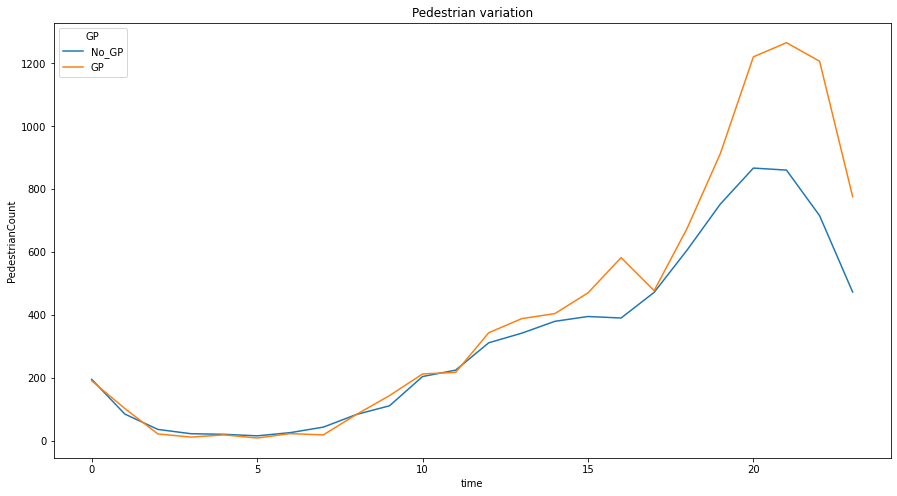

In [358]:
#Plot afl v non-afl movmeents, enter sensor_id, year and day of the week

plt.figure(figsize=(15,8))
sns.lineplot(x='time', y='PedestrianCount', hue='GP', 
             data = gp_merged_df[(gp_merged_df.sensor_id == 31) & 
                                (gp_merged_df.year == 2019) & 
                                (gp_merged_df.day == 'Saturday')]).set_title('Pedestrian variation')

plt.show()

In [359]:
def GPPedestrianVar(year, day, *sensor_ids):
  m = folium.Map(location=[sensor_location.latitude.mean(), 
                            sensor_location.longitude.mean()], 
                            zoom_start=14, control_scale=True, min_zoom=14, max_zoom = 16)

  for i in sensor_ids:
    data = gp_merged_df[(gp_merged_df.sensor_id == i) & 
                                (gp_merged_df.year == year) & 
                                (gp_merged_df.day == day)]

    pedestrian_chart = alt.Chart(data).mark_line().encode(
      x='time',
      y='PedestrianCount',
      color='GP')
    
    chart = json.loads(pedestrian_chart.to_json())

    popup = folium.Popup(max_width=350)
    folium.features.VegaLite(chart, height=200, width=350).add_to(popup)
    folium.Marker([data.iloc[i]['latitude'], 
                              data.iloc[i]['longitude']], tooltip = data.iloc[i]['sensor_id'], popup=popup).add_to(m)

  return(m)

In [367]:
pedestrian_variance = GPPedestrianVar(2018, 'Sunday',7,9,10,2,6,18,8,11, 31)
pedestrian_variance